In [2]:
import numpy as np
import dedalus.public as de
import sys

# Import data handling and postprocessing libraries
import pathlib
import subprocess
import h5py

# Import analysis libraries
import numpy as np
import numpy.linalg as la
import time
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.cm import ScalarMappable
from matplotlib import cm
from matplotlib import gridspec

import dedalus.public as de
from dedalus.tools import post
from dedalus.extras import flow_tools

import logging
logger = logging.getLogger(__name__)

# Font similar to LaTeX:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})

In [3]:
# Import Dedalus data

# open file
#filename = "snapshots_Re1e4_4096/snapshots_Re1e4_4096.h5"
filename = "snapshots_Re1e4_1024.h5"
file = h5py.File(filename, mode='r')
# File structure: [100(time),64(r),64(theta),64(z)]

# Read file into datasets
B_x = file.get('tasks')['Bx']
B_y = file.get('tasks')['By']
U = file.get('tasks')['u']
V = file.get('tasks')['v']
rho = file.get('tasks')['rho']
#temp = file.get('tasks')['temp']
t = np.array(B_x.dims[0]['sim_time'])
x = np.array(B_x.dims[2][0])
y = np.array(B_x.dims[1][0])
B_x = np.array(B_x)
B_y = np.array(B_y)
U = np.array(U)
V = np.array(V)
rho = np.array(rho)
#temp = np.array(temp)

In [4]:
# average timestep
dt = np.average([t[i+1]-t[i] for i in range(t.size-1)])#
print(len(t))

#print(np.max(np.gradient(B_x[0,:,:])[0]+np.gradient(B_y[0,:,:])[1]))

80


843587


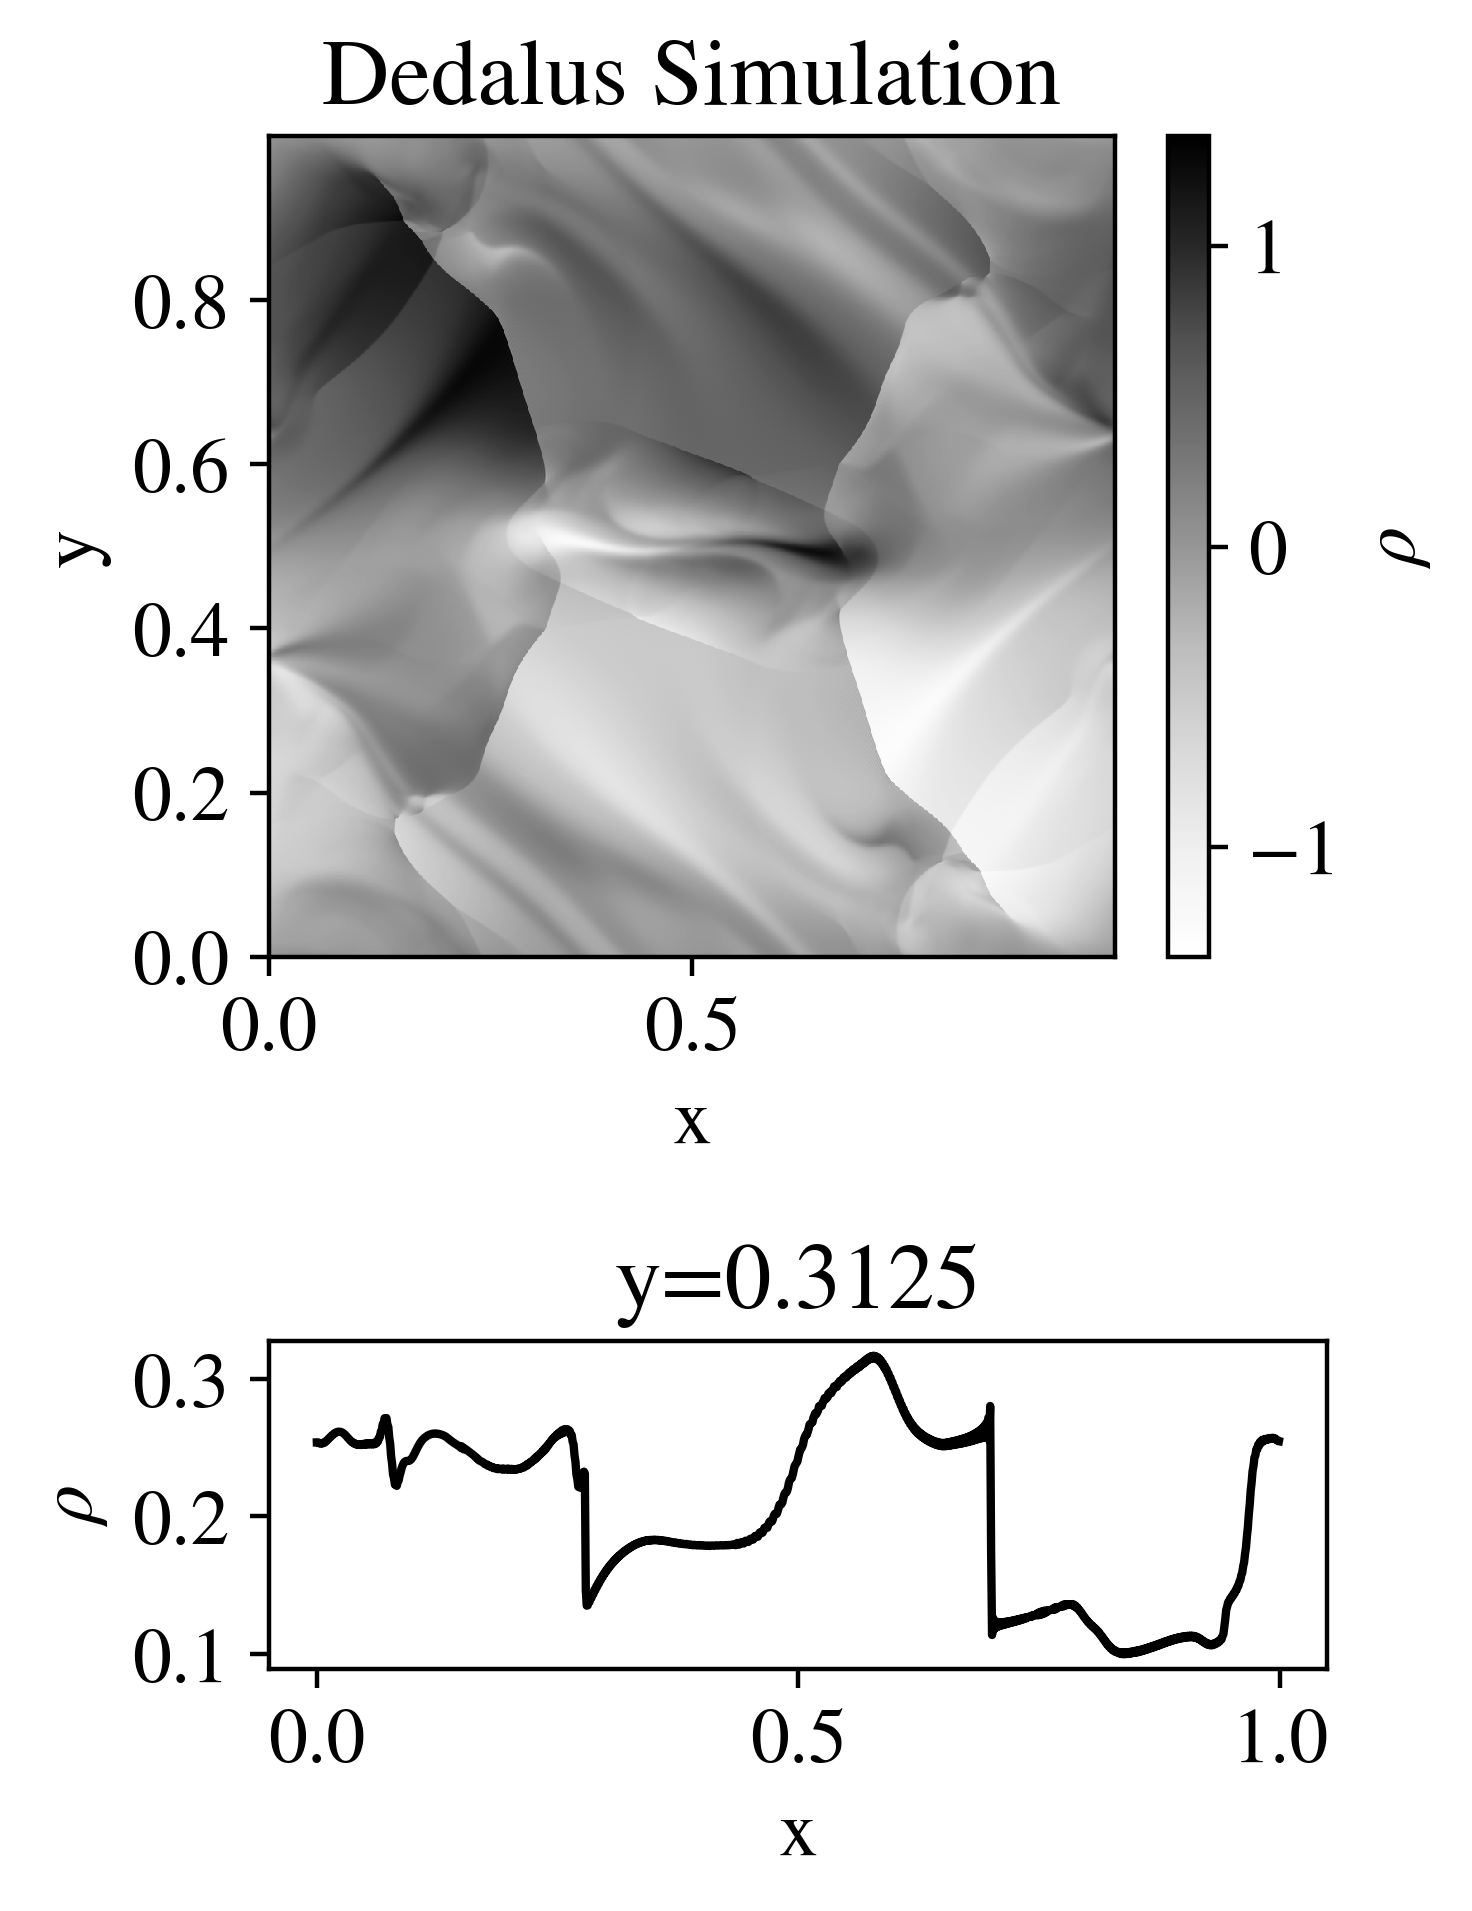

In [5]:
# Plot data
tindex=np.argmin(np.abs(t-0.5))
yindex = np.argmin(np.abs(y-0.3125))
# create grid for different subplots
fig = plt.figure(figsize=(4,5),dpi=400)
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[2.5, 1])

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

divb = np.gradient(B_x[tindex,:,:])[0]+np.gradient(B_y[tindex,:,:])[1]

m = ax1.pcolormesh(x,y, U[tindex,:,:].T,cmap="Greys")
n = 32
#ax1.quiver(x[::n],y[::n],U[tindex,:,:].T[::n,::n],V[tindex,:,:].T[::n,::n])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Dedalus Simulation")
fig.colorbar(m, ax=ax1,label=r"$\rho$",location='right')
#ax1.set_title("Orzsag-Tang Vortex: t=0.5")

ax2.plot(y,rho[tindex,:,yindex],c='k')
ax2.set_xlabel("x")
ax2.set_ylabel(r"$\rho$")
ax2.set_title("y=0.3125")

plt.tight_layout()
#plt.savefig("divb.png")
print(np.argmin(rho[tindex,:,:]))

In [6]:
# Basic DMD
# Code Adapted from Anna Guseva

# function to get the rank of the model
# default tolerance is set to remove all singular values 
# smaller than 1% of the maximum energy
def get_rank_s2(mydata, tol=0.01):
    Sigmab = la.svd(mydata, full_matrices=False, compute_uv=False)
    return np.where(np.cumsum(Sigmab**2)/(Sigmab**2).sum() >= (1-tol))[0][0] + 1

def plot_singular_values(data):
    Sigmab = la.svd(data, full_matrices=False, compute_uv=False)
    normed_singular_values = (Sigmab)/(Sigmab).max()
    fig,ax=plt.subplots()
    p = ax.scatter(range(normed_singular_values.size),normed_singular_values,facecolors='none', edgecolors='b')
    plt.semilogy()
    #ax.plot(range(normed_singular_values.size),np.zeros(normed_singular_values.size)+0.99, 'k--')
    ax.set_ylabel(r'$\sigma/\sigma_{max}$')
    ax.set_xlabel('n')
    plt.savefig("singularvalues1.pdf",bbox_inches='tight')
    return p

def get_DMD(X,dt,r=None):
    X1 = X[:,:-1]; X2=X[:,1:] # set up matrices X and X' shifted by a time step    
    U2, Sigma2, V2h = la.svd(X1,full_matrices=False)
    V2 = V2h.conj().T # transpose V2h because numpy svd does not do it for me
    # truncate the svd because I want a smaller matrix A
    if r == None: r = U2.shape[-1]
    U = U2[:,0:r]; Sigma = Sigma2[0:r]; V = V2[:,0:r]    
    # DMD decompostition projected on the largest svd modes
    Atilde = U.conj().T@X2@V@la.inv(np.diag(Sigma))
    D,W = la.eig(Atilde)
    Phi = U@W # come back to the n -dimentional space
    # calculate eigenvalues (check how)
    omega = np.log(D)/dt # continuous
    return Phi, omega, Atilde

def get_Henkel(X, d=4):
    # set up delay embedding
    time_length = np.shape(X)[1] - d
    observables_length = np.shape(X)[0]
    H = np.zeros((d*observables_length,time_length))
    for i in range(time_length):
       H[:,i] = np.ravel([X[:,i:i+d]]) # flatten array to get (x_1, x_2, ... x_d) etc.

    return H

# Estimate instantaneous coefficients
def rms_amps(Phi, data):
    aI = np.linalg.pinv(Phi)@data # instantaneous coefs through oblique projection of data on the DMD modes
    a2 = np.real(aI*aI.conj()) # multiply by conjugate to get aI^2
    return np.sqrt(a2.sum(axis=-1)/aI.shape[-1]) # rms in time

# sort DMD modes and eigenvalues by the real part of the eigenvalue (from high to low)
def sortreal(Phi, omega, amps):
    inds = np.real(omega).argsort()
    return Phi[...,inds[::-1]], omega[inds[::-1]], amps[inds[::-1]]

# calculate DMD model based on the initial snapshot, time array, basis DMD modes and the DMD continuous eigenvalues 
def get_model(ic, t, basis, eigs):
    y0 = la.lstsq(basis, ic, rcond=None)[0] # [0] - take the fit only and ignore the info about residuals, singular values etc
    r = basis.shape[-1]
    u_modes = np.zeros([r, len(t)], dtype='c16')
    for i in range(len(t)):
        u_modes[:,i] = y0*np.exp(eigs*(t[i]-t[0]))
    return basis@u_modes

# calculate DMD model based on the initial snapshot, time array, basis DMD modes and the DMD continuous eigenvalues 
def time_coef(ic, t, basis, eigs):
    y0 = la.lstsq(basis, ic, rcond=None)[0] # [0] - take the fit only and ignore the info about residuals, singular values etc
    r = basis.shape[-1]
    u_modes = np.zeros([r, len(t)], dtype='c16')
    for i in range(len(t)):
        u_modes[:,i] = y0*np.exp(eigs*(t[i]-t[0]))
    return u_modes

Data rank which preserves 99\% of energy:  8


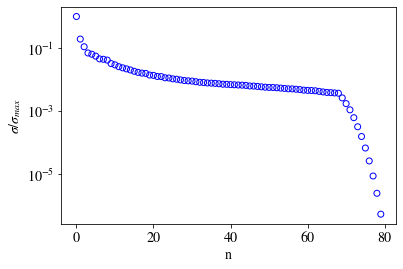

In [7]:
rhodata = rho.reshape(len(t), 1024**2).T # reshape 2D data as a collection of vectors
Bxdata = B_x.reshape(len(t), 1024**2).T 
Bydata = B_y.reshape(len(t), 1024**2).T 
Udata = U.reshape(len(t), 1024**2).T 
Vdata = V.reshape(len(t), 1024**2).T 
data = [rhodata, Bxdata, Bydata, Udata, Vdata]

#print(get_Henkel_DMD(rhodata, dt))
print('Data rank which preserves 99\% of energy: ', get_rank_s2(rhodata).T)
plot_singular_values(rhodata)

In [21]:
t1 = time.time()
DMD_results = []
koopman = []
for i in data:
    Phi, omega, Atilde = get_DMD(i, dt, r=12)
    amps = rms_amps(Phi, i)
    Phi, omega, amps = sortreal(Phi, omega, amps)
    DMD_results.append([Phi, omega, amps])
    koopman.append(Atilde)
t2 = time.time()

logger.info(f"Rank 8: Elapsed solve time: " + str(t2-t1) + ' seconds')

2023-04-26 15:12:00,572 __main__ 0/1 INFO :: Rank 8: Elapsed solve time: 95.05508804321289 seconds


(12, 12)


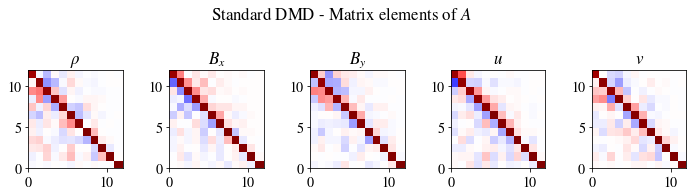

In [40]:
# Plots of matrix elements of learned model
print(koopman[0].shape)
fig, axes = plt.subplots(1,5, figsize=(10,2.8))
for i in range(len(data)):
    m=axes[i].pcolor(np.flip(koopman[i],axis=1),cmap="seismic",vmin=-1,vmax=1)
fig.suptitle(r"Standard DMD - Matrix elements of $A$")
axes[0].set_title(r"$\rho$")
axes[1].set_title(r"$B_x$")
axes[2].set_title(r"$B_y$")
axes[3].set_title(r"$u$")
axes[4].set_title(r"$v$")
plt.tight_layout()
#plt.savefig("matrixelements.pdf")

(1048576, 12)


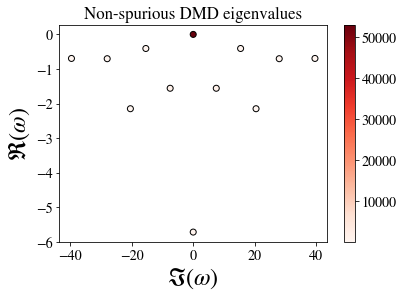

In [42]:
import matplotlib.cm as cm
clr1 = cm.Reds(np.linspace(0,1,30))

# Rho data
Phi, omega, amps = DMD_results[0][0], DMD_results[0][1], DMD_results[0][2]
print(Phi.shape)
fig, ax = plt.subplots()
sc = ax.scatter(omega[:].imag, omega[:].real, c=np.real(amps[:]*amps[:].conj()), cmap='Reds',  edgecolors='black', label=r'$r=8$')
#ax.plot(np.linspace(-30,30,100), np.zeros(100), 'k--')
ax.set_xlabel(r'$\Im (\omega)$', fontsize=24)
ax.set_ylabel(r'$\Re (\omega)$', fontsize=24)
ax.set_title("Non-spurious DMD eigenvalues")
plt.colorbar(sc,)
#ax.legend(loc="best")
#plt.savefig("exactdmdrhospectrum.pdf",bbox_inches='tight')

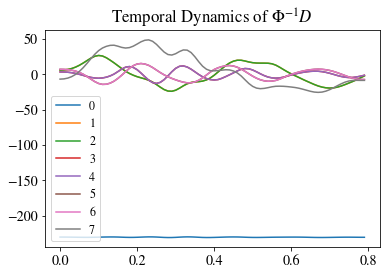

In [124]:
# check what is the temporal dynamics of different modes
# t is multiplied by dt
nst = 0
aI = np.linalg.pinv(Phi)@data[0] # real modal content
aL = time_coef(data[0][...,nst], t[nst:], Phi, omega) # linear modal coefficients
fig, ax = plt.subplots()
for i in range(8):
    #ax.plot(t, aI[i,:].real,label=i)
    ax.plot(t[nst:], aI[i,:].real,label=i)
ax.set_title(r"Temporal Dynamics of $\Phi^{-1}D$")
ax.legend(loc="best",fontsize=12)
#print(data.shape)

<ipython-input-135-0cca28d4fd76>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxinches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("DMD_eigenmode_rho_0_rank12.png", bboxinches="tight",dpi=400)


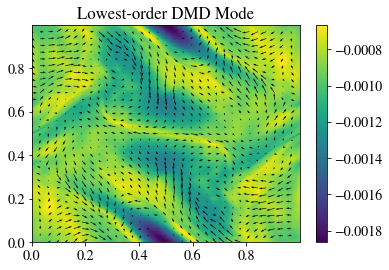

In [135]:
modenum=0
mode = Phi[:,modenum].reshape(1024,1024)

PhiU = DMD_results[3][0]
umode = PhiU[:,modenum].reshape(1024,1024)
PhiV = DMD_results[4][0]
vmode = PhiV[:,modenum].reshape(1024,1024)

m = plt.pcolormesh(x,y,np.real(mode).T)

q = plt.quiver(x[::n],y[::n],np.real(umode).T[::n,::n],np.real(vmode).T[::n,::n])

plt.title("Lowest-order DMD Mode")
plt.colorbar(m)

#plt.savefig("DMD_eigenmode_rho_0_rank12.png", bboxinches="tight",dpi=400)

In [22]:
# field structure based on two first modes and 
# ic is taken at 30th time step
# don't forget to multiply t by dt
nst = 0
nmodes = 12
DMD_model = []

for i in range(len(data)-4):
    Phi, omega, amps = DMD_results[i][0], DMD_results[i][1], DMD_results[i][2]
    model = get_model(data[i][...,nst], t[nst:], Phi[:,0:nmodes], omega[0:nmodes]).T
    model = model.reshape(t.size-nst,1024,1024)
    DMD_model.append(model)

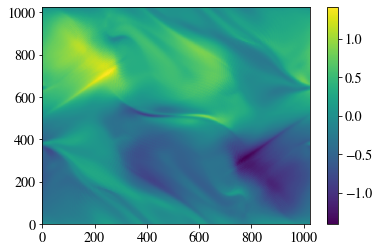

In [109]:
time_index = 50
m = plt.pcolormesh(np.real(DMD_model[3][time_index,:,:]).T)
plt.colorbar(m)

<ipython-input-118-22030b3b62ce>:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxinches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("difference.png",bboxinches="tight",dpi=400)


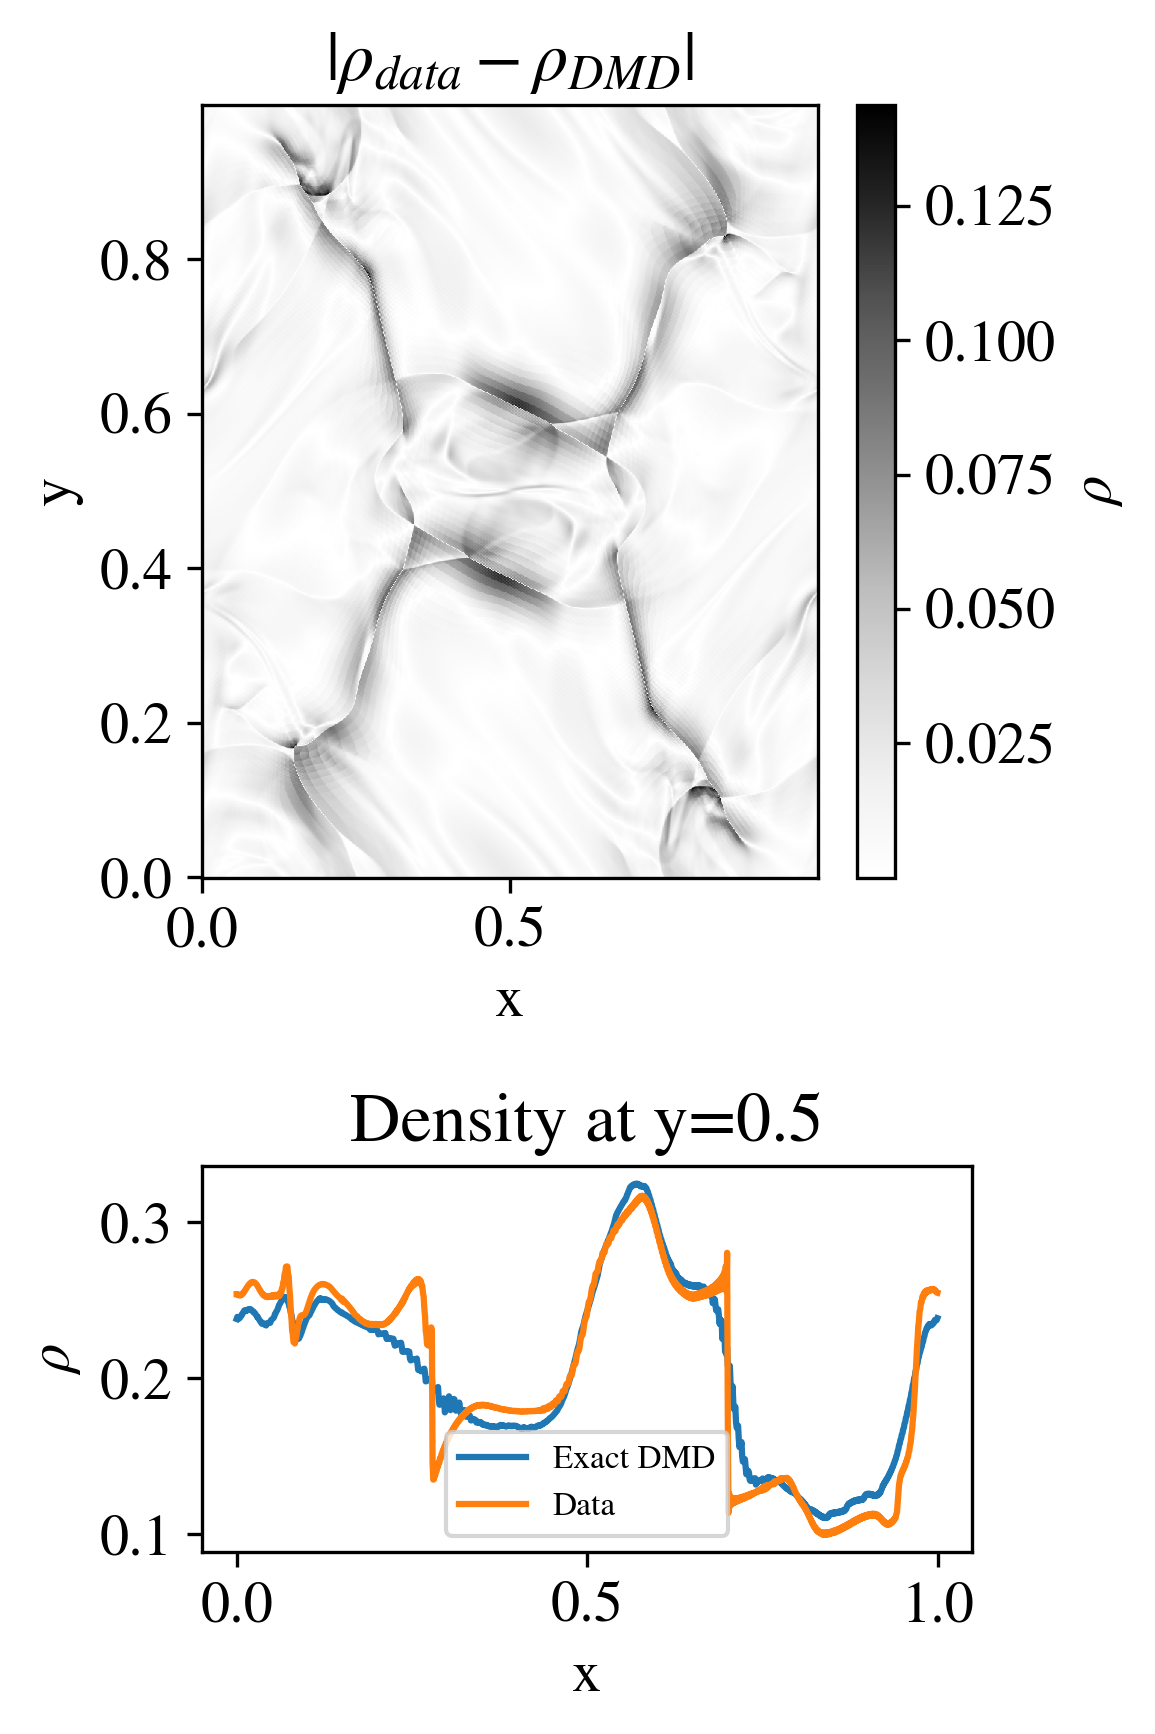

In [118]:
# Plot Model Data
tindex=np.argmin(np.abs(t-0.5))
yindex = np.argmin(np.abs(y-0.3125))

# create grid for different subplots
fig = plt.figure(figsize=(4,6),dpi=300)
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[2, 1])

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

m = ax1.pcolormesh(x,y, np.abs(rho[tindex,:,:].T-DMD_model[0][tindex,:,:].T),cmap="Greys")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(m, ax=ax1,label=r"$\rho$")
ax1.set_title(r"$|\rho_{data}-\rho_{DMD}|$")
ax2.plot(y, np.real(DMD_model[0][tindex,:,yindex]),label="Exact DMD")
ax2.plot(y, np.real(rho[tindex,:,yindex]), label="Data")
ax2.set_xlabel("x")
ax2.set_ylabel(r"$\rho$")
ax2.set_title("Density at y=0.5")
ax2.legend(loc="best",fontsize=8)
plt.tight_layout()
plt.savefig("difference.png",bboxinches="tight",dpi=400)

In [1]:
# Time-delay embedding (Henkel DMD)

t1 = time.time()
HODMD_results = []
HO_koopman = []
for i in data[:1]:
    Phi, omega, Atilde = get_DMD(get_Henkel(i, d=5), dt, r=8)
    amps = rms_amps(Phi, get_Henkel(i, d=5))
    Phi, omega, amps = sortreal(Phi, omega, amps)
    HODMD_results.append([Phi, omega, amps])
    HO_koopman.append(Atilde)
t2 = time.time()

logger.info(f"Rank 8: Elapsed solve time: " + str(t2-t1) + ' seconds')

NameError: name 'time' is not defined

(4194304, 12) (12,) (12,)


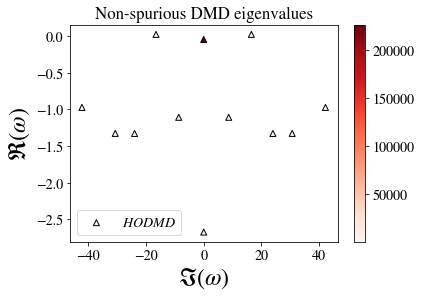

In [ ]:
fig, ax = plt.subplots()
#Phi, omega, amps = DMD_results[0][0], DMD_results[0][1], DMD_results[0][2]
#print(Phi.shape, omega.shape, amps.shape)
PhiH, omegaH, ampsH = HODMD_results[0][0], HODMD_results[0][1], HODMD_results[0][2]
print(PhiH.shape, omegaH.shape, ampsH.shape)
#sc = ax.scatter(omega[:].imag, omega[:].real, c=np.real(amps[:]*amps[:].conj()), cmap='Reds',  edgecolors='black', label=r'$DMD$')
sc = ax.scatter(omegaH[:].imag, omegaH[:].real, c=np.real(ampsH[:]*ampsH[:].conj()), cmap='Reds',  edgecolors='black', marker="^", label=r'$HODMD$')

#ax.plot(np.linspace(-30,30,100), np.zeros(100), 'k--')
ax.set_xlabel(r'$\Im (\omega)$', fontsize=24)
ax.set_ylabel(r'$\Re (\omega)$', fontsize=24)
ax.set_title("Non-spurious DMD eigenvalues")
plt.colorbar(sc,)
ax.legend(loc="best")
#plt.savefig("exactdmdrhospectrum.pdf",bbox_inches='tight')

(12, 12)


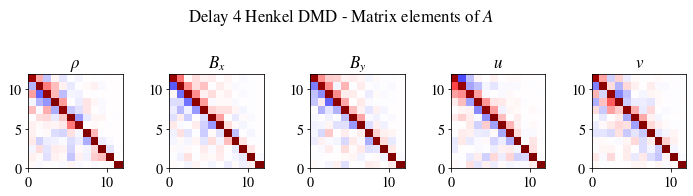

In [ ]:
# Plots of matrix elements of learned model
print(HO_koopman[0].shape)
fig, axes = plt.subplots(1,5, figsize=(10,2.8))
for i in range(len(data)):
    m=axes[i].pcolor(np.flip(HO_koopman[i],axis=1),cmap="seismic",vmin=-1,vmax=1)
fig.suptitle(r"Delay 4 Henkel DMD - Matrix elements of $A$")
axes[0].set_title(r"$\rho$")
axes[1].set_title(r"$B_x$")
axes[2].set_title(r"$B_y$")
axes[3].set_title(r"$u$")
axes[4].set_title(r"$v$")
plt.tight_layout()
#plt.savefig("matrixelements_HO.pdf")

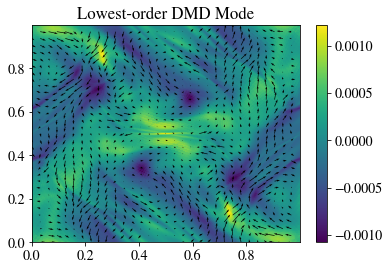

In [18]:
modenum=0
mode = PhiH[::4,modenum].reshape(1024,1024)

PhiU = HODMD_results[3][0]
umode = PhiU[::4,modenum].reshape(1024,1024)
PhiV = HODMD_results[4][0]
vmode = PhiV[::4,modenum].reshape(1024,1024)

m = plt.pcolormesh(x,y,np.real(mode).T)
n=32
q = plt.quiver(x[::n],y[::n],np.real(umode).T[::n,::n],np.real(vmode).T[::n,::n])

plt.title("Lowest-order DMD Mode")
plt.colorbar(m)

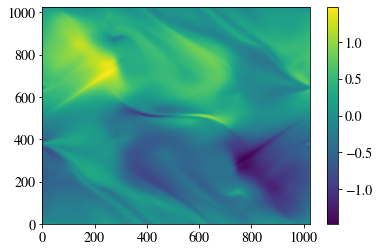

In [19]:
nst = 0
nmodes = 12
HODMD_model = []

for i in range(len(data)):
    Phi, omega, amps = HODMD_results[i][0], HODMD_results[i][1], HODMD_results[i][2]
    model = get_model(data[i][...,nst], t[nst:], Phi[::4,0:nmodes], omega[0:nmodes]).T
    model = model.reshape(t.size-nst,1024,1024)
    HODMD_model.append(model)

time_index = 50
m = plt.pcolormesh(np.real(HODMD_model[3][time_index,:,:]).T)
plt.colorbar(m)

<ipython-input-23-119a98443b94>:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxinches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("difference.png",bboxinches="tight",dpi=400)


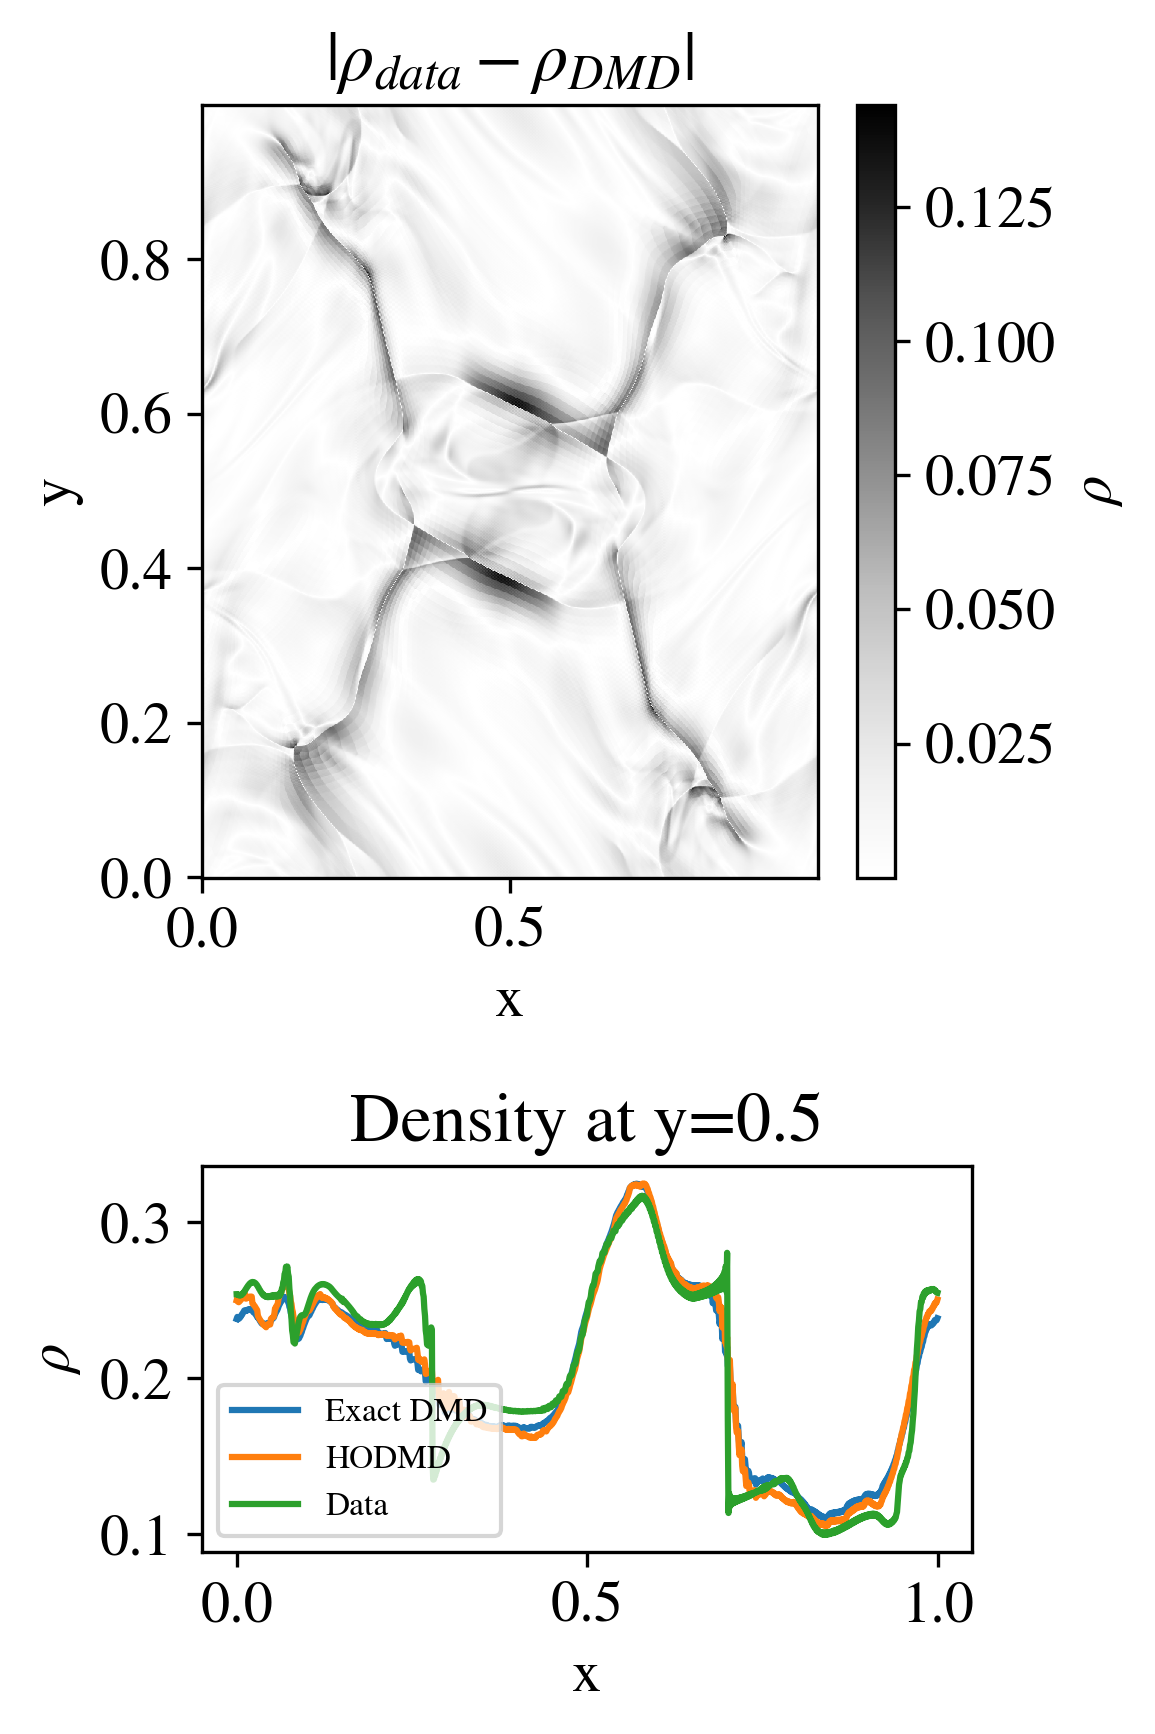

In [23]:
# Plot Model Data
tindex=np.argmin(np.abs(t-0.5))
yindex = np.argmin(np.abs(y-0.3125))

# create grid for different subplots
fig = plt.figure(figsize=(4,6),dpi=300)
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[2, 1])

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

m = ax1.pcolormesh(x,y, np.abs(rho[tindex,:,:].T-HODMD_model[0][tindex,:,:].T),cmap="Greys")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(m, ax=ax1,label=r"$\rho$")
ax1.set_title(r"$|\rho_{data}-\rho_{DMD}|$")
ax2.plot(y, np.real(DMD_model[0][tindex,:,yindex]),label="Exact DMD")
ax2.plot(y, np.real(HODMD_model[0][tindex,:,yindex]),label="HODMD")
ax2.plot(y, np.real(rho[tindex,:,yindex]), label="Data")
ax2.set_xlabel("x")
ax2.set_ylabel(r"$\rho$")
ax2.set_title("Density at y=0.5")
ax2.legend(loc="best",fontsize=8)
plt.tight_layout()
#plt.savefig("difference.png",bboxinches="tight",dpi=400)